# NLP Disaster Tweets Kaggle Mini-Project
#### Introduction to Deep Learning, University of Colorado, Boulder

The goal of this Kaggle mini-project is to classify whether a given tweet refers to a natural disaster or not.  Words can be use in a variety of ways.  While in some cases it may be optimal to attempt to classify an article or text based on the presence and frequency of words, in many other situations it is necessary to recognize the manner in which a word is being employed.  The sequence of words is important.  As tweets have historically been limited to only 140 characters, an effective machine learning model will need to derive as much meaning as possible from those characters.  Therefore, for this project I will test a number of Recurrent Neural Network (RNN) architectures to solve the task.  In particular I will employ SimpleRNN, Long Short-Term Memory (LSTM), and Gated Recurrent Units (GRUs), as RNNs learn based on the ordering of elements (words) in a given series.

The data and guidelines for this task are available on Kaggle, at the following link location:
> https://www.kaggle.com/c/nlp-getting-started/overview

The project is also published on GitHub here: 
> https://github.com/slilly4/NLP-Natural-Disasters

In [2]:
!pip install scikeras   

import os
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import models
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, add, Input, concatenate, LSTM, Embedding, SpatialDropout1D, Bidirectional, SimpleRNN, GRU
from keras import regularizers, optimizers
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras import backend as K


# Exporatory Data Analysis

To begin this project, I will first evaluate the project files that are available for the Kaggle competition

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


It appears that we have been supplied with a csv file of test data, a csv file of training data, and a sample submission file.  I will load the training, test, and submission files into dataframe to evaluate them further.

In [88]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv",dtype=str)
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv",dtype=str)
submission_df = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv",dtype=str)


As we can see below, the training data includes an ID, keywords, locations, the tweet text, and the target (1 denoting that it does refer to a natural disaster, while 0 denotes that it does not).  We have 7,613 tweets on which we can train our model.  This is not a lot of data, so it may be difficult to prevent our models from overfitting.

In [5]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


It is clear from looking at the dataframe that there are many missing values.  In fact there are over 2,500 missing locations.  I will need to drop this feature from the dataframe.  Also there are a fair number of keywords that are missing.  Fortunately, there are tweets for each object in the dataset.  I will likely choose to retain just the tweet information and drop everything else.  The keyword will be present in the tweet itself.

In [123]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   object
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   object
dtypes: object(5)
memory usage: 297.5+ KB


In [7]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
train_df.groupby("location")["location"].count().sort_values(0, ascending=False)

/tmp/ipykernel_28/1759288547.py:1: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  train_df.groupby("location")["location"].count().sort_values(0, ascending=False)


location
USA               104
New York           71
United States      50
London             45
Canada             29
                 ... 
Hueco Mundo         1
Hughes, AR          1
Huntington, WV      1
Huntley, IL         1
åø\_(?)_/åø         1
Name: location, Length: 3341, dtype: int64

In [9]:
train_df.groupby("keyword")["keyword"].count().sort_values(0, ascending=False)

/tmp/ipykernel_28/3937054706.py:1: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  train_df.groupby("keyword")["keyword"].count().sort_values(0, ascending=False)


keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [12]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

For the most part, the true natural disaster tweets appear more serious; however, there are some that are comical.  

In [11]:
pd.options.display.max_colwidth = 200
train_df[train_df["target"]=="1"].head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [13]:
train_df[train_df["target"]=="0"].head(20)

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
20,31,NaN,NaN,this is ridiculous....,0
21,32,NaN,NaN,London is cool ;),0
22,33,NaN,NaN,Love skiing,0
23,34,NaN,NaN,What a wonderful day!,0
24,36,NaN,NaN,LOOOOOOL,0


In [14]:
train_df.groupby("target")["target"].count()

target
0    4342
1    3271
Name: target, dtype: int64

There are about 1,100 more negatively classed tweets than true disaster tweets.  However, it is still a fairly balanced dataset.

<Axes: xlabel='target'>

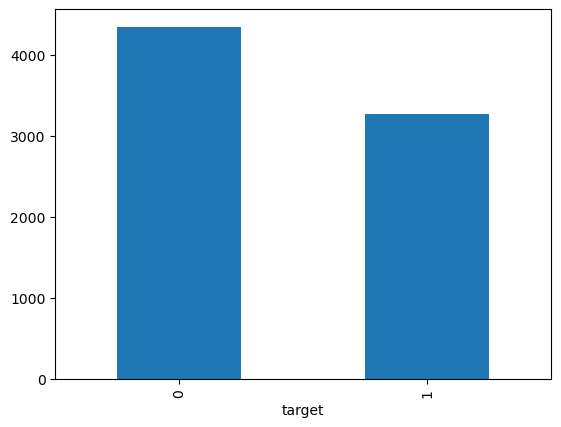

In [15]:
train_df.groupby("target")["target"].count().plot(kind='bar')

The test data is also missing locations and keywords.  This confirms that it would be best to just drop these features.  The tweets themselves should be enough for the training.

In [16]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3


In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   object
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: object(4)
memory usage: 102.1+ KB


In [18]:
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [17]:
text_lengths = []

for row in train_df["text"].astype(str):
    text_lengths.append(len(row))

Most of the tweets bump up again the 140-character limit.  Interestingly some have a more than 140 characters.  This might be due to the way that emojis are being encoded in this dataset.  

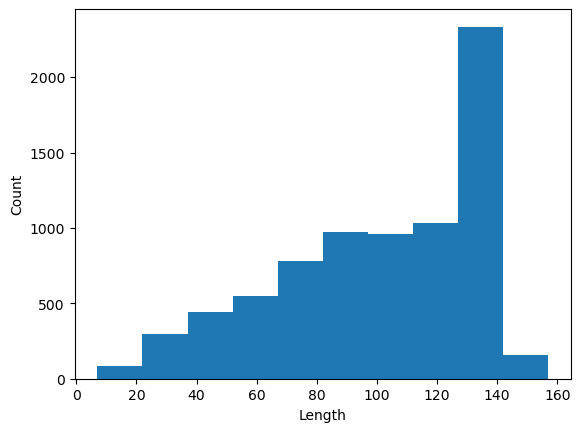

In [18]:
plt.hist(text_lengths)
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

In [22]:
def word_freq(Target):
    count_vectors = CountVectorizer()
    count = count_vectors.fit_transform(train_df[train_df["target"] == Target]["text"])
    words = count_vectors.get_feature_names_out()
    word_values = count.sum(0)
    word_values_arr = np.array(word_values)
    word_indices = word_values_arr[0].argsort()[-50:][::-1]
    plt.figure(figsize=(15,3))
    plt.bar(words[word_indices], word_values_arr[0][word_indices])
    plt.xticks(rotation = 90)
    plt.title(Target)
    plt.show()

The most common words are not likely to be very helpful in classification.  There are a lot of URLs in both target classes, so it will be prudent to remove the links.  Other common words like "and" "to" "of" also likely will not help with classification.  I will try training after removing these. 

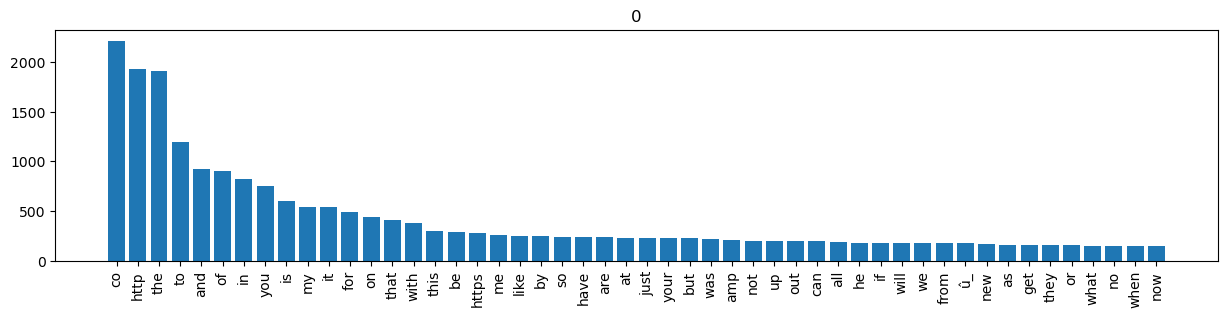

In [23]:
word_freq("0")

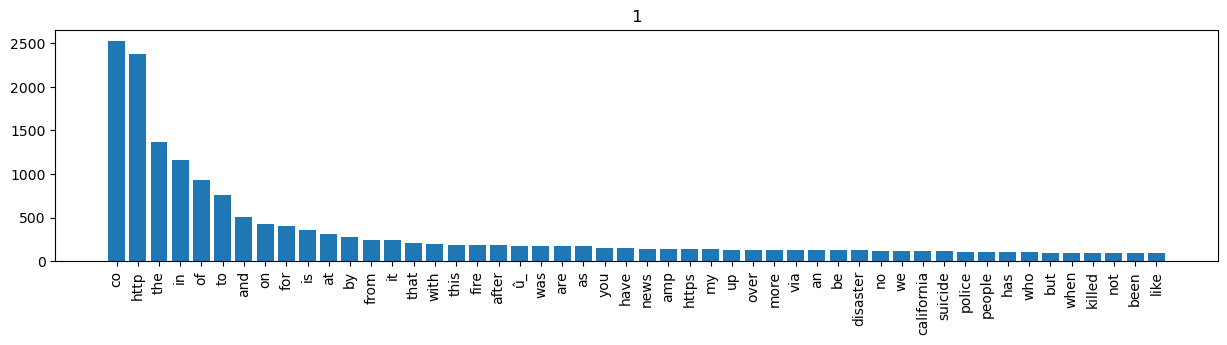

In [25]:
word_freq("1")

# Data Cleaning and Preparation

To prepare the data, I will first combine both the training and test datasets into a single dataset.  This will be necessary for tokenizing the data.  We want to make sure that we are using a common dictionary for both datasets.  We will split them apart again in a later step.

In [4]:
All_X = train_df["text"].append(test_df["text"], ignore_index=True)

/tmp/ipykernel_28/2039958361.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_X = train_df["text"].append(test_df["text"], ignore_index=True)


I will also standardize the data by making everything lowercase.  I will then remove URLs and punctuation.

In [6]:
All_X = All_X.str.lower()
All_X = All_X.str.replace(r'http.*\s','')
All_X = All_X.str.replace(r'\shttp[A-Za-z0-9\:\.\/]*$','')
All_X = All_X.str.replace(r'[\.\:\*\@\?\!\#\'\;\(\)\-\|]','')
All_X = All_X.str.replace(r'&amp','')

/tmp/ipykernel_28/4034471532.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  All_X = All_X.str.replace(r'http.*\s','')
/tmp/ipykernel_28/4034471532.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  All_X = All_X.str.replace(r'\shttp[A-Za-z0-9\:\.\/]*$','')
/tmp/ipykernel_28/4034471532.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  All_X = All_X.str.replace(r'[\.\:\*\@\?\!\#\'\;\(\)\-\|]','')


Here I import a set of stop words.  I will iterate over each tweet, and I will only keep those words that are not included in the stop words set.

In [7]:
stop_words = set(stopwords.words('english'))

In [6]:
All_X

0        our deeds are the reason of this earthquake ma...
1                    forest fire near la ronge sask canada
2        all residents asked to shelter in place are be...
3        13,000 people receive wildfires evacuation ord...
4        just got sent this photo from ruby alaska as s...
                               ...                        
10871    earthquake safety los angeles ûò safety faste...
10872    storm in ri worse than last hurricane my city3...
10873                     green line derailment in chicago
10874             meg issues hazardous weather outlook hwo
10875    cityofcalgary has activated its municipal emer...
Name: text, Length: 10876, dtype: object

In [8]:
for i in range(len(All_X)):
    stripped_tweet = ""
    for word in All_X[i].split():
        if word not in stop_words:
            stripped_tweet = stripped_tweet + word + " "
            
    All_X[i] = stripped_tweet

The updated dataframe below shows how the common words have been removed.

In [18]:
All_X

0                                                                          deeds reason earthquake may allah forgive us 
1                                                                                 forest fire near la ronge sask canada 
2                              residents asked shelter place notified officers evacuation shelter place orders expected 
3                                                          13,000 people receive wildfires evacuation orders california 
4                                                               got sent photo ruby alaska smoke wildfires pours school 
                                                              ...                                                       
10871                                                           earthquake safety los angeles ûò safety fasteners xrwn 
10872    storm ri worse last hurricane city3others hardest hit yard looks like bombed around 20000k still without power 
10873                           

I will now tokenize the tweets.  This will keep keep the ordering of the words within the tweets

In [9]:
tokenizer = Tokenizer(
    num_words=3000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    analyzer=None
)
tokenizer.fit_on_texts(All_X.values)

I will also pad the resulting vectors so that they all have the same length.  That will be necessary to train the models.

In [10]:
All_X_Vector = tokenizer.texts_to_sequences(All_X.values)
All_X_Vector = pad_sequences(All_X_Vector)

Now I split the data back into training and test sets, and I create a target (y) set for training.

In [11]:
X_train = All_X_Vector[:7613]
X_test = All_X_Vector[7613:]

In [23]:
X_train

array([[   0,    0,    0, ...,   62, 1749,   11],
       [   0,    0,    0, ...,  115,  678, 1421],
       [   0,    0,    0, ...,  651, 1511, 1130],
       ...,
       [   0,    0,    0, ..., 1411,  462, 1412],
       [   0,    0,    0, ..., 1094, 2157,  214],
       [   0,    0,    0, ...,   87,  573,    8]], dtype=int32)

In [12]:
y_train = train_df["target"].astype(int) 

In [25]:
y_train

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [26]:
X_train.shape

(7613, 19)

The length of each tweet vector is 19 tokens.  This will be the input size for our models.  

# Simple RNN Model

For the Simple RNN model, I will begin with a single RNN layer, and attempt to build up a more complex model from there.  Since this is a binary classification task, I will use the Sigmoid activation function for the final dense layer, and I will use binary crossentropy for a loss function. 

A SimpleRNN model includes layer units that feed back data from previous timestamps into the next timestamp.  This therefore allow for some "memory" concerning sequential patterns, and for our purposes, it allows for the recognition of the way the a word (token) might be related to others

In order to tune parameters, I will wrap my model in a KerasClassifier so that I can use gridsearch to test various parameter options.  The first parameter I will test for is the number of units in the hidden layer.

During the tuning process, I will use 3-fold cross validation so that all of the training data is available.

In [28]:
def create_SimpleRNN(units):
    model = Sequential()
    model.add(SimpleRNN(units=units, input_shape=(19,1), activation="relu"))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [29]:
simpleRNN_model = KerasClassifier(model=create_SimpleRNN, optimizer="Adam", batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__units=[32, 64, 128, 256, 512])
grid = GridSearchCV(estimator=simpleRNN_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)


In [30]:
print(grid_result.best_params_)
print(grid_result.best_score_)
# grid_result.cv_results_

{'model__units': 64}
0.5331690921822226


64 units in the hidden layer worked the best.  I used just 3 epochs for training because during testing I found that overfitting started to occur after about 3 epochs.  Next I will test for the best optimizer option.

In [31]:
simpleRNN_model = KerasClassifier(model=create_SimpleRNN, units=64, batch_size=32, epochs = 3, verbose=0)
param_grid = dict(optimizer=['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'])
grid = GridSearchCV(estimator=simpleRNN_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [32]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'optimizer': 'RMSprop'}
0.5424957283116106


Using the RMSprop had the best result, and our performance increased by about 1%.  Next I will test whether adding an additional RNN layer will help the model.  

In [33]:
def create_SimpleRNN(units):
    model = Sequential()
    model.add(SimpleRNN(units=64, input_shape=(19,1), activation="relu", return_sequences=True))
    model.add(SimpleRNN(units=units, activation="relu"))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [34]:
simpleRNN_model = KerasClassifier(model=create_SimpleRNN, batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__units=[32, 64, 128, 256, 512])
grid = GridSearchCV(estimator=simpleRNN_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [35]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__units': 64}
0.5411834453451151


Unfortunately, the model actually performed worse.  Therefore, I will not attempt to add additional SimpleRNN layers.  I will next see if adding dropout parameters will inprove the performance.

In [36]:
def create_SimpleRNN(dropout):
    model = Sequential()
    model.add(SimpleRNN(units=64, input_shape=(19,1), activation="relu", dropout=dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [37]:
simpleRNN_model = KerasClassifier(model=create_SimpleRNN, batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__dropout=[.1, .2, .3, .4, .5])
grid = GridSearchCV(estimator=simpleRNN_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [38]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__dropout': 0.1}
0.5390795682786279


Adding a dropout parameter did not improve the performance much.  Next I will look at whether values for the recurrent dropout works any better.

In [39]:
def create_SimpleRNN(dropout):
    model = Sequential()
    model.add(SimpleRNN(units=64, input_shape=(19,1), activation="relu", recurrent_dropout=dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [40]:
simpleRNN_model = KerasClassifier(model=create_SimpleRNN, batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__dropout=[.1, .2, .3, .4, .5])
grid = GridSearchCV(estimator=simpleRNN_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [41]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__dropout': 0.2}
0.5679751084009199


Great, adding the recurrent dropout did improve the performance.  Next I will take a look at the activation function.  I may have errored in assuming the relu would work the best.  I had used relu frequently for past neural network tasks, but after some reading, it seems that tanh might be more appropriate.

In [110]:
def create_SimpleRNN(activation):
    model = Sequential()
    model.add(SimpleRNN(units=64, activation=activation, recurrent_dropout=.2, input_shape=(19,1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [111]:
simpleRNN_model = KerasClassifier(model=create_SimpleRNN, batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__activation=['relu','tanh','sigmoid'])
grid = GridSearchCV(estimator=simpleRNN_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [112]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__activation': 'sigmoid'}
0.5682380412656022


This is a bit of a surprise for me.  The sigmoid activation function brought about the best results.  Some tutorials on RNNs suggest adding a Embedding layer, as this can reduce the dimensionality.  

In [113]:
def create_SimpleRNN(output_dim):
    model = Sequential()
    model.add(Embedding(3000, output_dim=output_dim, input_length = 19))
    model.add(SimpleRNN(units=64, activation='sigmoid', recurrent_dropout=.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [120]:
simpleRNN_model = KerasClassifier(model=create_SimpleRNN, batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__output_dim=[16,32,64,128,256,512])
grid = GridSearchCV(estimator=simpleRNN_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [121]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__output_dim': 128}
0.6599213178967566


Lastly, I will check for the optimal number of epochs to train the model. 

In [62]:
def create_SimpleRNN():
    model = Sequential()
    model.add(Embedding(3000, output_dim=512, input_length = 19))
    model.add(SimpleRNN(units=64, activation='sigmoid', recurrent_dropout=.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [63]:
simpleRNN_model = KerasClassifier(model=create_SimpleRNN, batch_size=32, verbose=0)
param_grid = dict(epochs=[2,4,6,8,10])
grid = GridSearchCV(estimator=simpleRNN_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [67]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'epochs': 2}
0.5703402099673454


Now I will evaluate the model performance on a epoch by epoch basis.  Hopefuly we can discern how many epochs are ideal or if other changes should be made.  In particular, I will try different values of the learning rate so that we can smoothly get to the best accuracy.

In [77]:
optimizer = keras.optimizers.RMSprop(lr=0.0001)
simpleRNN_model = Sequential()
simpleRNN_model.add(Embedding(3000, output_dim=512, input_length = 19))
simpleRNN_model.add(SimpleRNN(units=64, activation='sigmoid', recurrent_dropout=.2))
simpleRNN_model.add(Dense(1, activation='sigmoid'))
simpleRNN_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])

simpleRNN_model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 19, 512)           1536000   
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 64)                36928     
                                                                 
 dense_48 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,572,993
Trainable params: 1,572,993
Non-trainable params: 0
_________________________________________________________________


In [78]:
st = time.process_time()
simpleRNN_stats = simpleRNN_model.fit(X_train, y_train, epochs = 30, batch_size=32, verbose = 1, shuffle=True, validation_split=0.2)
et = time.process_time()
res = et - st
print('Execution time:', et - st, 'seconds')

Epoch 1/30
191/191 [==============================] - 9s 35ms/step - loss: 0.6804 - accuracy: 0.5773 - precision_48: 0.4639 - recall_48: 0.0301 - auc_48: 0.5243 - binary_accuracy: 0.5773 - val_loss: 0.6924 - val_accuracy: 0.5345 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00 - val_auc_48: 0.6276 - val_binary_accuracy: 0.5345
Epoch 2/30
191/191 [==============================] - 6s 32ms/step - loss: 0.6737 - accuracy: 0.5798 - precision_48: 0.8000 - recall_48: 0.0016 - auc_48: 0.5906 - binary_accuracy: 0.5798 - val_loss: 0.6870 - val_accuracy: 0.5345 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00 - val_auc_48: 0.6689 - val_binary_accuracy: 0.5345
Epoch 3/30
191/191 [==============================] - 6s 31ms/step - loss: 0.6620 - accuracy: 0.5865 - precision_48: 0.8548 - recall_48: 0.0207 - auc_48: 0.6889 - binary_accuracy: 0.5865 - val_loss: 0.6839 - val_accuracy: 0.5384 - val_precision_48: 0.7143 - val_recall_48: 0.0141 - val_auc_48: 0.6911 - val_binary_accuracy

In [13]:
def visualize_stats(stats,num_epochs):
    stats_list = []
    
    for key, values in stats.history.items():
        stats_list.append((key,values))
    
    num_rows = 2
    num_cols = 6
    stat_index = 0

    fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15,6))

    for i in range(num_rows):
        for j in range(num_cols):  
            axes[i,j].plot(range(1,num_epochs+1),stats_list[stat_index][1])
            axes[i,j].set_title(stats_list[stat_index][0], fontsize=7)
            axes[i,j].xaxis.set_tick_params(labelsize=5)
            axes[i,j].yaxis.set_tick_params(labelsize=5)
            stat_index += 1

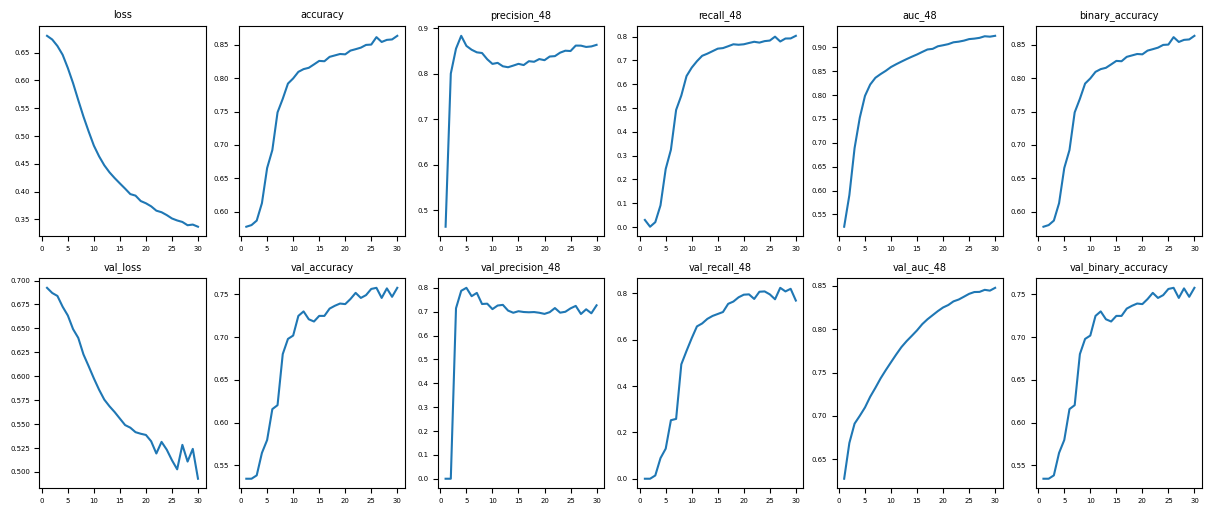

In [79]:
visualize_stats(simpleRNN_stats,30)

The validation accuracy continues to improve through about 25 epochs of training.  Recall also begins to flatten out about then, while the precision begins to decrease about about 5 epochs.  The validation loss decreases to about .5.  Overall accuracy peaks at about .75.  

|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.3368 | 0.4929 |
|Accuracy | 0.8635 | 0.7577 |
|Precision | 0.8632 | 0.7267 | 
|Recall | 0.8029 | 0.7687 |
|AUC | 0.9240 | 0.8477 | 

In [83]:
# This function is to assign binary classes to the continuous sigmoid outputs

def assign_binary_class(a):
    if a > .5:
        return 1
    else:
        return 0

In [113]:
simpleRNN_predictions = simpleRNN_model.predict(X_test)
simpleRNN_pred_binary = np.apply_along_axis(assign_binary_class, 1, simpleRNN_predictions)

102/102 [==============================] - 0s 3ms/step


In [114]:
simpleRNN_submission = submission_df.copy()
simpleRNN_submission["target"] = simpleRNN_pred_binary

In [115]:
simpleRNN_submission.to_csv('/kaggle/working/simpleRNN_submission.csv', index=False)

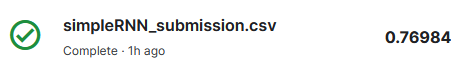

Using the SimpleRNN model, I was able to achieve a Kaggle competition score of about .77.  I will now attempt to use other RNN models to improve on this performance.

# Long Short-Term Memory (LSTM

Long Short-Term Memory uses more complex layer units which allow greater ability to control how much memory or past information should be applied later in the layer.  However, in doing so it uses more parameters, which may make it more intensive to train.  However, with the small amount of data to train on, I'm not very concerned.  We will begin by using Gridsearch to determine the optimal number of units in the LSTM layer.

In [14]:
def create_LSTM(units):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(19,1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [15]:
LSTM_model = KerasClassifier(model=create_LSTM, optimizer="Adam", batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__units=[32, 64, 128, 256, 512])
grid = GridSearchCV(estimator=LSTM_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)


In [16]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__units': 32}
0.6016063908993236


We will use 32 units in the LSTM layer.  Now we will check to find the optimal output dimension of the embedding layer.  In the previous model, there were large gains in accuracy when the Embedding layer was applied, so I assume the same will occur in this instance.  

In [17]:
def create_LSTM(output_dim):
    model = Sequential()
    model.add(Embedding(3000, output_dim=output_dim, input_length = 19))
    model.add(LSTM(units=32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [18]:
LSTM_model = KerasClassifier(model=create_LSTM, optimizer="Adam", batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__output_dim=[32, 64, 128, 256, 512])
grid = GridSearchCV(estimator=LSTM_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [19]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__output_dim': 32}
0.7376895495394197


Indeed, adding the embedding layer with a output reduced to 32 units increased performance by over 10%.  Next we will see whether adding additioanl LSTM layers might improve the model at all.

In [22]:
def create_LSTM(units):
    model = Sequential()
    model.add(Embedding(3000, output_dim=32, input_length = 19))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(LSTM(units=units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [23]:
LSTM_model = KerasClassifier(model=create_LSTM, optimizer="Adam", batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__units=[32, 64, 128, 256, 512])
grid = GridSearchCV(estimator=LSTM_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [24]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__units': 256}
0.7390032820275163


There was a slight increase in performance.  I am hesitant to keep the second layer as it is really only a marginal difference.  I will keep it for now, but will likely drop it later in this tuning process.

In [26]:
def create_LSTM(dropout):
    model = Sequential()
    model.add(Embedding(3000, output_dim=32, input_length = 19))
    model.add(LSTM(units=32, return_sequences=True, dropout=dropout))
    model.add(LSTM(units=256, dropout=dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [27]:
LSTM_model = KerasClassifier(model=create_LSTM, optimizer="Adam", batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__dropout=[.1, .2, .3, .4, .5])
grid = GridSearchCV(estimator=LSTM_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [28]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__dropout': 0.5}
0.7378216113109898


Add dropouts in the LSTM layers did not improve performance at all.  Now we will see if recurrent dropout helps at all.

In [29]:
def create_LSTM(recurrent_dropout):
    model = Sequential()
    model.add(Embedding(3000, output_dim=32, input_length = 19))
    model.add(LSTM(units=32, return_sequences=True, recurrent_dropout=recurrent_dropout))
    model.add(LSTM(units=256, recurrent_dropout=recurrent_dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [30]:
LSTM_model = KerasClassifier(model=create_LSTM, optimizer="Adam", batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__recurrent_dropout=[.1, .2, .3, .4, .5])
grid = GridSearchCV(estimator=LSTM_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [31]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__recurrent_dropout': 0.5}
0.7245548648585127


The recurrent dropout does not help.  However, I might attempt this again later in the tuning process.

In [34]:
def create_LSTM():
    model = Sequential()
    model.add(Embedding(3000, output_dim=32, input_length = 19))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(LSTM(units=256))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [35]:
LSTM_model = KerasClassifier(model=create_LSTM, batch_size=32, epochs = 3, verbose=0)
param_grid = dict(optimizer=['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'])
grid = GridSearchCV(estimator=LSTM_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [36]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'optimizer': 'Adam'}
0.7387413845354062


The best optimzer in this case is Adam.  Next I will check how performance changes over each epoch.  This will help to determine whether there is a need to change the learning rate or other parameters.  

In [34]:
LSTM_model = Sequential()
LSTM_model.add(Embedding(3000, output_dim=32, input_length = 19))
LSTM_model.add(LSTM(units=32, return_sequences=True))
LSTM_model.add(LSTM(units=256))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
LSTM_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 19, 32)            96000     
                                                                 
 lstm_9 (LSTM)               (None, 19, 32)            8320      
                                                                 
 lstm_10 (LSTM)              (None, 256)               295936    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 400,513
Trainable params: 400,513
Non-trainable params: 0
_________________________________________________________________


In [35]:
st = time.process_time()
LSTM_stats = LSTM_model.fit(X_train, y_train, epochs = 10, batch_size=32, verbose = 1, shuffle=True, validation_split=0.2)
et = time.process_time()
res = et - st
print('Execution time:', et - st, 'seconds')

Epoch 1/10
191/191 [==============================] - 16s 63ms/step - loss: 0.5590 - accuracy: 0.7135 - precision_5: 0.7903 - recall_5: 0.4340 - auc_5: 0.7672 - binary_accuracy: 0.7135 - val_loss: 0.4653 - val_accuracy: 0.7925 - val_precision_5: 0.8673 - val_recall_5: 0.6544 - val_auc_5: 0.8525 - val_binary_accuracy: 0.7925
Epoch 2/10
191/191 [==============================] - 4s 22ms/step - loss: 0.3809 - accuracy: 0.8361 - precision_5: 0.8519 - recall_5: 0.7389 - auc_5: 0.8999 - binary_accuracy: 0.8361 - val_loss: 0.4523 - val_accuracy: 0.7892 - val_precision_5: 0.8012 - val_recall_5: 0.7278 - val_auc_5: 0.8573 - val_binary_accuracy: 0.7892
Epoch 3/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3287 - accuracy: 0.8616 - precision_5: 0.8742 - recall_5: 0.7838 - auc_5: 0.9259 - binary_accuracy: 0.8616 - val_loss: 0.4696 - val_accuracy: 0.7827 - val_precision_5: 0.7953 - val_recall_5: 0.7179 - val_auc_5: 0.8501 - val_binary_accuracy: 0.7827
Epoch 4/10
191/191 [====

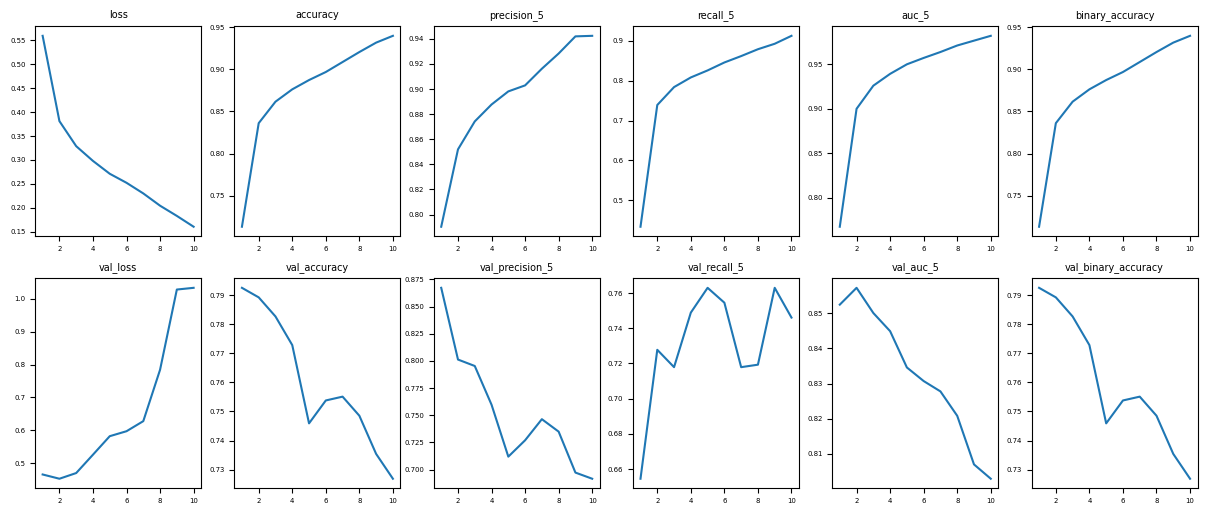

In [36]:
visualize_stats(LSTM_stats,10)

Unfortunately, all of the metrics move in the wrong direction.  I surmise that the learning rate it too high, so I played with different rates to obtain a better performance.  I also found that I could obtain improved performance by removing the second LSTM layer and adding in the recurring drop out.  

In [117]:
optimizer = keras.optimizers.Adam(lr=0.00005)
LSTM_model = Sequential()
LSTM_model.add(Embedding(3000, output_dim=32, input_length = 19))
LSTM_model.add(LSTM(units=32, recurrent_dropout=.2))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
LSTM_model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 19, 32)            96000     
                                                                 
 lstm_6 (LSTM)               (None, 32)                8320      
                                                                 
 dense_51 (Dense)            (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [61]:
st = time.process_time()
LSTM_stats = LSTM_model.fit(X_train, y_train, epochs = 20, batch_size=32, verbose = 1, shuffle=True, validation_split=0.2)
et = time.process_time()
res = et - st
print('Execution time:', et - st, 'seconds')

Epoch 1/20
191/191 [==============================] - 19s 86ms/step - loss: 0.6887 - accuracy: 0.5775 - precision_40: 0.4758 - recall_40: 0.0422 - auc_40: 0.5461 - binary_accuracy: 0.5775 - val_loss: 0.6868 - val_accuracy: 0.5345 - val_precision_40: 0.0000e+00 - val_recall_40: 0.0000e+00 - val_auc_40: 0.7024 - val_binary_accuracy: 0.5345
Epoch 2/20
191/191 [==============================] - 15s 80ms/step - loss: 0.6766 - accuracy: 0.5793 - precision_40: 0.0000e+00 - recall_40: 0.0000e+00 - auc_40: 0.6042 - binary_accuracy: 0.5793 - val_loss: 0.6792 - val_accuracy: 0.5345 - val_precision_40: 0.0000e+00 - val_recall_40: 0.0000e+00 - val_auc_40: 0.7122 - val_binary_accuracy: 0.5345
Epoch 3/20
191/191 [==============================] - 15s 81ms/step - loss: 0.6643 - accuracy: 0.5793 - precision_40: 0.0000e+00 - recall_40: 0.0000e+00 - auc_40: 0.6788 - binary_accuracy: 0.5793 - val_loss: 0.6733 - val_accuracy: 0.5345 - val_precision_40: 0.0000e+00 - val_recall_40: 0.0000e+00 - val_auc_40: 0

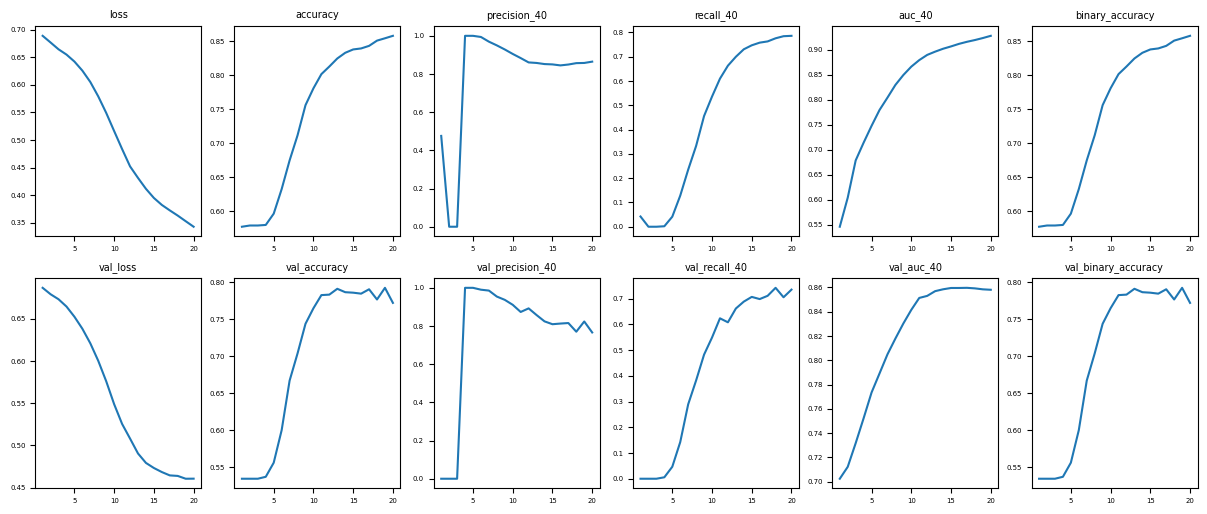

In [62]:
visualize_stats(LSTM_stats,20)

Now there is a much smoother increase in accuracy.  Overall validation accuracy improves to about .8, while the Area Under the Curve reaches about .86.  Recall hits .7 while precision is about .8.  

|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.3528 | 0.460 |
|Accuracy | 0.8547 | 0.7925 |
|Precision | 0.8579 | 0.8237 | 
|Recall | 0.7845 | 0.7052 |
|AUC | 0.9282 | 0.8585 | 

From the previous run, the highest validation accuracy occured at 13 epochs, so I will retrain the model with 13 epochs and submit the results to Kaggle

In [118]:
st = time.process_time()
LSTM_stats = LSTM_model.fit(X_train, y_train, epochs = 13, batch_size=32, verbose = 1, shuffle=True)
et = time.process_time()
res = et - st
print('Execution time:', et - st, 'seconds')

Epoch 1/13
238/238 [==============================] - 22s 83ms/step - loss: 0.6891 - accuracy: 0.5625 - precision_51: 0.4180 - recall_51: 0.0468 - auc_51: 0.5388 - binary_accuracy: 0.5625
Epoch 2/13
238/238 [==============================] - 20s 83ms/step - loss: 0.6747 - accuracy: 0.5703 - precision_51: 0.0000e+00 - recall_51: 0.0000e+00 - auc_51: 0.6188 - binary_accuracy: 0.5703
Epoch 3/13
238/238 [==============================] - 22s 92ms/step - loss: 0.6621 - accuracy: 0.5710 - precision_51: 1.0000 - recall_51: 0.0015 - auc_51: 0.7008 - binary_accuracy: 0.5710
Epoch 4/13
238/238 [==============================] - 20s 86ms/step - loss: 0.6473 - accuracy: 0.5908 - precision_51: 0.9937 - recall_51: 0.0480 - auc_51: 0.7432 - binary_accuracy: 0.5908
Epoch 5/13
238/238 [==============================] - 21s 89ms/step - loss: 0.6262 - accuracy: 0.6427 - precision_51: 0.9808 - recall_51: 0.1718 - auc_51: 0.7786 - binary_accuracy: 0.6427
Epoch 6/13
238/238 [==============================] 

In [119]:
LSTM_predictions = LSTM_model.predict(X_test)
LSTM_pred_binary = np.apply_along_axis(assign_binary_class, 1, LSTM_predictions)

102/102 [==============================] - 1s 6ms/step


In [120]:
LSTM_submission = submission_df.copy()
LSTM_submission["target"] = LSTM_pred_binary

In [121]:
LSTM_submission.to_csv('/kaggle/working/LSTM_submission.csv', index=False)

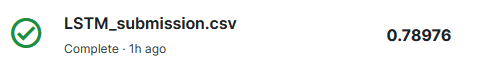

The result is higher than the SimpleRNN model, but not as high as I hoped for.  I was hoping for an accuracy of about .8.  Next I will turn to the GRU model.

# GRU (Gated Recurrent Unit)

Gated Recurring Units have some similarities with LSTM; however, they strip out some of the weights in order to simplify it. This results in fewer parameters, but it may also result in poorer performance.  We will undertake the same tuning process as the other models to find good performance.  

We will begin by searching for the optimal number of units in the GRU layer.

In [38]:
def create_GRU(units):
    model = Sequential()
    model.add(GRU(units=units, input_shape=(19,1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [40]:
GRU_model = KerasClassifier(model=create_GRU, optimizer="Adam", batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__units=[32, 64, 128, 256, 512])
grid = GridSearchCV(estimator=GRU_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [41]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__units': 32}
0.5876795426635105


This found that 32 units works best for our data.  We will now check the output parameter for the embedding layer.  As see in the previous models, I expect that the Embedding layer, which reduces the dimensionality of the token dictionary, will improve our performance quite a bit.

In [42]:
def create_GRU(output_dim):
    model = Sequential()
    model.add(Embedding(3000, output_dim=output_dim, input_length = 19))
    model.add(GRU(units=32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [43]:
GRU_model = KerasClassifier(model=create_GRU, optimizer="Adam", batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__output_dim=[32, 64, 128, 256, 512])
grid = GridSearchCV(estimator=GRU_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [44]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__output_dim': 32}
0.725077520932904


The embedding layer does improve the model by about 15%.  I also want to check whether running the GRU layer in both directions (instead of just forward feed) can help bring about better results.  

In [45]:
def create_GRU(output_dim):
    model = Sequential()
    model.add(Embedding(3000, output_dim=output_dim, input_length = 19))
    model.add(Bidirectional(GRU(32)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [46]:
GRU_model = KerasClassifier(model=create_GRU, optimizer="Adam", batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__output_dim=[32, 64, 128, 256, 512])
grid = GridSearchCV(estimator=GRU_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [47]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__output_dim': 32}
0.7317770026978704


Yes, there was a marginal performance boost by adding the Bidirectional GRU.  Next I want to see whether additional GRU layers will help.

In [50]:
def create_GRU(units):
    model = Sequential()
    model.add(Embedding(3000, output_dim=32, input_length = 19))
    model.add(Bidirectional(GRU(32,return_sequences=True)))
    model.add(Bidirectional(GRU(units=units)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [51]:
GRU_model = KerasClassifier(model=create_GRU, optimizer="Adam", batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__units=[32, 64, 128, 256, 512])
grid = GridSearchCV(estimator=GRU_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [52]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__units': 256}
0.7303321920421472


No further gain was found.  I will next check whether adding the dropout parameters helps.

In [ ]:
def create_GRU(dropout):
    model = Sequential()
    model.add(Embedding(3000, output_dim=32, input_length = 19))
    model.add(Bidirectional(GRU(32,dropout=dropout)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    return model

In [56]:
GRU_model = KerasClassifier(model=create_GRU, optimizer="Adam", batch_size=32, epochs = 3, verbose=0)
param_grid = dict(model__dropout=[.1, .2, .3, .4, .5])
grid = GridSearchCV(estimator=GRU_model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [57]:
print(grid_result.best_params_)
print(grid_result.best_score_)

{'model__dropout': 0.3}
0.7347995140789445


Yes, a dropout of .3 does help.  Now let's see whether we have smooth training by looking at performance at each epoch.  I have lowered the learning rate in the expectation that we will need smaller steps to prevent jumpy gains/losses

In [34]:
optimizer = keras.optimizers.Adam(lr=0.00005)
GRU_model = Sequential()
GRU_model.add(Embedding(3000, output_dim=32, input_length = 19))
GRU_model.add(Bidirectional(GRU(32, dropout=.3)))
GRU_model.add(Dense(1, activation='sigmoid'))
GRU_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
GRU_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 19, 32)            96000     
                                                                 
 bidirectional_30 (Bidirecti  (None, 64)               12672     
 onal)                                                           
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 108,737
Trainable params: 108,737
Non-trainable params: 0
_________________________________________________________________


In [35]:
st = time.process_time()
GRU_stats = GRU_model.fit(X_train, y_train, epochs = 20, batch_size=32, verbose = 1, shuffle=True, validation_split=0.2)
et = time.process_time()
res = et - st
print('Execution time:', et - st, 'seconds')

Epoch 1/20
191/191 [==============================] - 25s 115ms/step - loss: 0.6863 - accuracy: 0.5757 - precision_31: 0.4647 - recall_31: 0.0566 - auc_31: 0.5287 - binary_accuracy: 0.5757 - val_loss: 0.6884 - val_accuracy: 0.5345 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_auc_31: 0.6402 - val_binary_accuracy: 0.5345
Epoch 2/20
191/191 [==============================] - 2s 10ms/step - loss: 0.6781 - accuracy: 0.5793 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - auc_31: 0.5988 - binary_accuracy: 0.5793 - val_loss: 0.6878 - val_accuracy: 0.5345 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_auc_31: 0.6939 - val_binary_accuracy: 0.5345
Epoch 3/20
191/191 [==============================] - 2s 10ms/step - loss: 0.6732 - accuracy: 0.5793 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - auc_31: 0.6861 - binary_accuracy: 0.5793 - val_loss: 0.6845 - val_accuracy: 0.5345 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_auc_31: 0.

Validation accuracy peaked at about .78.  I want to see whether adding the recurring dropout with different values helps at all, so I will run the training again.  

In [102]:
optimizer = keras.optimizers.Adam(lr=0.0001)
GRU_model = Sequential()
GRU_model.add(Embedding(3000, output_dim=32, input_length = 19))
GRU_model.add(Bidirectional(GRU(32, dropout=.3, recurrent_dropout=.3)))
GRU_model.add(Dense(1, activation='sigmoid'))
GRU_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
GRU_model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 19, 32)            96000     
                                                                 
 bidirectional_39 (Bidirecti  (None, 64)               12672     
 onal)                                                           
                                                                 
 dense_50 (Dense)            (None, 1)                 65        
                                                                 
Total params: 108,737
Trainable params: 108,737
Non-trainable params: 0
_________________________________________________________________


In [45]:
st = time.process_time()
GRU_stats = GRU_model.fit(X_train, y_train, epochs = 20, batch_size=32, verbose = 1, shuffle=True, validation_split=0.2)
et = time.process_time()
res = et - st
print('Execution time:', et - st, 'seconds')

Epoch 1/20
191/191 [==============================] - 38s 174ms/step - loss: 0.6837 - accuracy: 0.5801 - precision_35: 0.6087 - recall_35: 0.0055 - auc_35: 0.5090 - binary_accuracy: 0.5801 - val_loss: 0.6888 - val_accuracy: 0.5345 - val_precision_35: 0.0000e+00 - val_recall_35: 0.0000e+00 - val_auc_35: 0.6774 - val_binary_accuracy: 0.5345
Epoch 2/20
191/191 [==============================] - 32s 168ms/step - loss: 0.6732 - accuracy: 0.5793 - precision_35: 0.0000e+00 - recall_35: 0.0000e+00 - auc_35: 0.6666 - binary_accuracy: 0.5793 - val_loss: 0.6832 - val_accuracy: 0.5345 - val_precision_35: 0.0000e+00 - val_recall_35: 0.0000e+00 - val_auc_35: 0.7511 - val_binary_accuracy: 0.5345
Epoch 3/20
191/191 [==============================] - 32s 168ms/step - loss: 0.6538 - accuracy: 0.5823 - precision_35: 1.0000 - recall_35: 0.0070 - auc_35: 0.7587 - binary_accuracy: 0.5823 - val_loss: 0.6585 - val_accuracy: 0.5417 - val_precision_35: 1.0000 - val_recall_35: 0.0155 - val_auc_35: 0.7791 - val_b

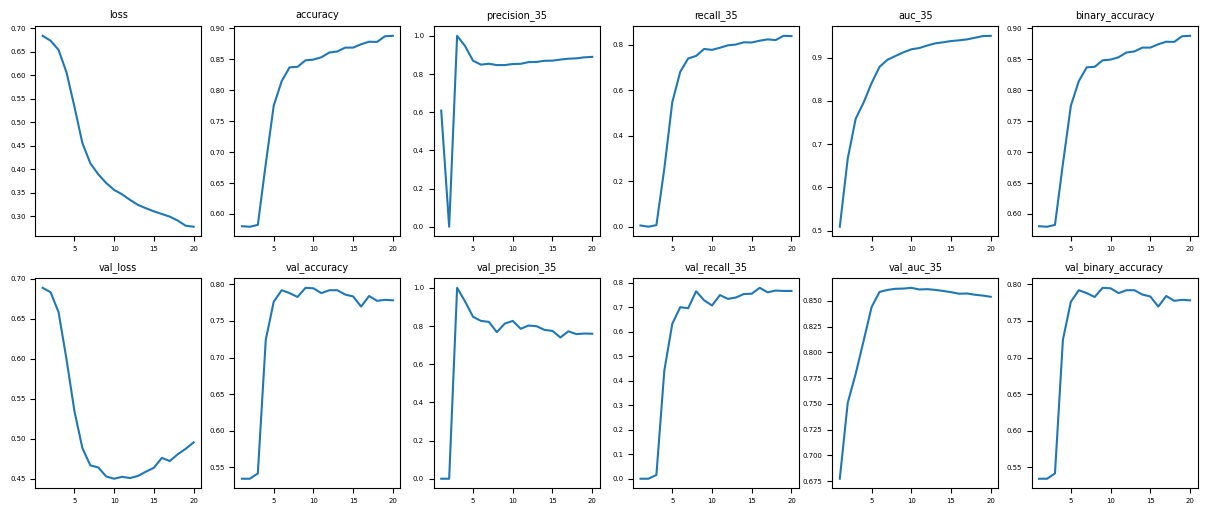

In [47]:
visualize_stats(GRU_stats,20)

Our model is achieving an accuracy of about .79.  This seems comparable to the LSTM model.  The performance gains are relatively smooth, so I'm happy with the learning rate.  

The Validation precision is about .8 while the recall also hits about .8.  The validation AUC is about .85.  

|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.3238 | 0.45 |
|Accuracy | 0.8609 | 0.7919 |
|Precision | 0.8623 | 0.8025 | 
|Recall | 0.7966 | 0.7334 |
|AUC | 0.9222 | 0.8613 | 

Since the best validation results came after epoch 12, I will retrain the model with 12 epochs and submit the results to Kaggle.

In [103]:
st = time.process_time()
GRU_stats = GRU_model.fit(X_train, y_train, epochs = 12, batch_size=32, verbose = 1, shuffle=True)
et = time.process_time()
res = et - st
print('Execution time:', et - st, 'seconds')

Epoch 1/12
238/238 [==============================] - 46s 174ms/step - loss: 0.6868 - accuracy: 0.5555 - precision_50: 0.4185 - recall_50: 0.0887 - auc_50: 0.5189 - binary_accuracy: 0.5555
Epoch 2/12
238/238 [==============================] - 41s 174ms/step - loss: 0.6732 - accuracy: 0.5703 - precision_50: 0.0000e+00 - recall_50: 0.0000e+00 - auc_50: 0.7051 - binary_accuracy: 0.5703
Epoch 3/12
238/238 [==============================] - 42s 174ms/step - loss: 0.6347 - accuracy: 0.6249 - precision_50: 0.9501 - recall_50: 0.1339 - auc_50: 0.7716 - binary_accuracy: 0.6249
Epoch 4/12
238/238 [==============================] - 42s 176ms/step - loss: 0.5562 - accuracy: 0.7663 - precision_50: 0.8719 - recall_50: 0.5347 - auc_50: 0.8207 - binary_accuracy: 0.7663
Epoch 5/12
238/238 [==============================] - 42s 174ms/step - loss: 0.4701 - accuracy: 0.8082 - precision_50: 0.8595 - recall_50: 0.6619 - auc_50: 0.8689 - binary_accuracy: 0.8082
Epoch 6/12
238/238 [===========================

In [104]:
GRU_predictions = GRU_model.predict(X_test)
GRU_pred_binary = np.apply_along_axis(assign_binary_class, 1, GRU_predictions)

102/102 [==============================] - 2s 14ms/step


In [108]:
GRU_submission = submission_df.copy()
GRU_submission["target"] = GRU_pred_binary

In [109]:
GRU_submission.to_csv('/kaggle/working/GRU_submission.csv', index=False)

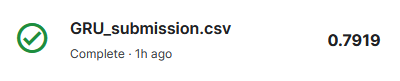

# Analysis and Discussion

The following table shows a comparison of the 3 models trained during this project:

|Metric|SimpleRNN|LSTM|GRU|
|:----|:--------:|:--------:|:--------:|
|Loss | 0.4929 | 0.460 | 0.45 |
|Accuracy | 0.7577 | 0.7925 | 0.7919 |
|Precision |  0.7267 | 0.8237 | 0.8025 | 
|Recall | 0.7687 | 0.7052 | 0.7334 |
|AUC | 0.8477 | 0.8585 | 0.8613 | 
|Kaggle | 0.76984 | 0.78976 | 0.7919 | 
|Epochs | 30 | 13 | 12 |
|Computation Time | 288.3 | 420.5 | 859.5 |
|# Parameters | 1,572,993 | 104,353 | 108,737 |


After the tuning process, both the LSTM and GRU models were very similar.  The only difference was that the GRU had an additional dropout parameter.  The parameters and optimal number of epochs were nearly the same.  However, computation time was twice that of the LSTM for the GRU model, and the GRU model performed slightly better; that that could be accounted for by normal variation.  It is not likely to be a statistically significant difference.  The SimpleRNN model wound up with three times as many parameters due to the larger output dimension for the embedding layer, but it trained the fasted of any of the models.  It also lagged in performance by a points.  The GRU also had the highest validation AUC (.86), while SimpleRNN had the highest Recall.

Overall, this classification task proved to be difficult.  Using only the training data that was provided, I was not able to increase model performance above about .79.  However, with the small dataset, this is not a horrible outcome.  Potential options to improve performance are to use a pre-trained model, and then add in additional training for this particular task. This would leverage the existing language proficiency of the pre-trained model to bring about a better result.  

A positive outcome of this project was greater familiarity with using gridsearch for neural networks.  I had used gridsearch for assignments in the Supervised and Unsupervised learning courses; however, I had not taken the opportunity to learn how to employ it with neural networks.  In this assignment I learned about how to use wrap my models in a KerasClassifier to then test a variety of parameter values.  A downsize to this approach was that it was necessary to stipulate how many epochs would be needed for the gridsearch.  I did some initial trials to see how many epochs were needed, but it may have made more sense to tune the learning rates first instead of last.  It was difficult to identify the best accuracies when there was not smooth learning.  In fact some of the models initially had the highest performance with the first epoch.  Therefore, looking for performance on the 3rd epoch was actually identifying decreasing performance.  I will need to look into how to better employ gridsearch when the best performance can occur at different epochs.  Also, it was not clear initially which parameters to tune first.  In the SimpleRNN model I probably could had a better tuning process if I began with the embedding layer.  I did not initially realize how much impact that dimensionality reduction would have on the task.  It alone increased performance by 10%.

Another positive for this project was the use of cross validation for tuning.  Since the dataset was small, this was especially important.  3-fold cross validation did increase the time needed for parameter selection, though.  Each gridsearch increased in execution time because it was necessary to do everything three times.  I also thought it was good to retrain the models using all of the data prior to making a submission to Kaggle.  However, the increased data might have changed how the models performed.  For instance, I might have been using the wrong number of epochs with all the data compared to 80% of the data.  

A question that I have is why the GRU model performed better than the LSTM.  My understanding was that GRU was actually a simplification of LSTM, so I should expect better performance with the LSTM.  This raises the possibility that my tuning process for the GRU was better than for the LSTM.  I might need to go back to see if I can squeeze some additional performance fromthe LSTM model.  

